## 주제 : 주유소 데이터 수집 및 분석  
###     1. 서울시 구별로상표, 주유소명, 주소, 유종별 평균가격(보통 휘발유, 경유), 부가정보 가져오기  
####        1-1. 정보 추출
####        1-2. 브랜드 별 비교

--------------

### 1. 서울시 구별로상표, 주유소명, 주소, 유종별 평균가격(보통 휘발유, 경유), 부가정보 가져오기  

####        1-1. 정보 추출

- 모둘 import

In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementNotInteractableException
from selenium.webdriver.common.action_chains import ActionChains  #동작을 하나로 묶기
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import json


from glob import glob #파일을 확인할 수 있는!
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
from tqdm import tqdm_notebook
from urllib.request import urlopen, Request
import pandas as pd

import numpy as np
import googlemaps

- SITE 접속

In [2]:
options = webdriver.ChromeOptions()

prefs = {'download.default_directory' : '../../data/17.gas_station_price',
         'download.prompt_for_download' : False}

options.add_experimental_option('prefs' , prefs)

url = "https://www.opinet.co.kr/searRgSelect.do"
driver = webdriver.Chrome(service=Service("/home/min/dev_ws/EDA/driver/chromedriver"), #드라이버 경로는 절대경로로
                          options=options)

driver.get(url)

- 시/도 LIST 출력 및 서울시 고정

In [3]:
sido = driver.find_element(By.ID,"SIDO_NM0")
sido_list = sido.find_elements(By.TAG_NAME,"option")

sido_name_list= []
for idx, sido_name in enumerate(sido_list):
    print(str(idx) + ". " + sido_name.get_attribute("value"))
    sido_name_list.append(sido_name.get_attribute("value"))

0. 
1. 서울특별시
2. 부산광역시
3. 대구광역시
4. 인천광역시
5. 광주광역시
6. 대전광역시
7. 울산광역시
8. 세종특별자치시
9. 경기도
10. 강원특별자치도
11. 충청북도
12. 충청남도
13. 전북특별자치도
14. 전라남도
15. 경상북도
16. 경상남도
17. 제주특별자치도


In [4]:
sido_name_list = sido_name_list[1:]

sido_name_list

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원특별자치도',
 '충청북도',
 '충청남도',
 '전북특별자치도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [5]:
len(sido_name_list)

17

In [6]:
print(sido_name_list[0])
sido.send_keys(sido_name_list[0])

서울특별시


- 구 LIST 출력

In [7]:
gu = driver.find_element(By.ID,"SIGUNGU_NM0")
gu_list = gu.find_elements(By.TAG_NAME,"option")

gu_name_list= []
for idx, gu_name in enumerate(gu_list):
    print(str(idx) + ". " + gu_name.get_attribute("value"))
    gu_name_list.append(gu_name.get_attribute("value"))

0. 
1. 강남구
2. 강동구
3. 강북구
4. 강서구
5. 관악구
6. 광진구
7. 구로구
8. 금천구
9. 노원구
10. 도봉구
11. 동대문구
12. 동작구
13. 마포구
14. 서대문구
15. 서초구
16. 성동구
17. 성북구
18. 송파구
19. 양천구
20. 영등포구
21. 용산구
22. 은평구
23. 종로구
24. 중구
25. 중랑구


In [8]:
gu_name_list = gu_name_list[1:]

In [9]:
len(gu_name_list)

25

In [10]:
gu.send_keys(gu_name_list[1])

- 구별로 주유소 정보 가져오기 (연료 별로 분류되어 있기 때문에 연료 선택 탭 정보 가져오기)

In [11]:
fuel = driver.find_element(By.ID,"templ_list0") #연료정보 보관 ID
# fuel = driver.find_elements(By.CLASS_NAME,"tab_type2 mgb_7") class로는 왜 안찾아질까?

tab_list = fuel.find_elements(By.TAG_NAME,"li") #연료 종류 tab 클릭
tab_list[1].click() #보통휘발유 

In [12]:
fuel_name_list=[]
for a in tab_list:
    tag_name=a.find_element(By.TAG_NAME,"a").get_attribute("title")
    fuel_name_list.append(tag_name)

fuel_name_list

['고급휘발유', '보통휘발유', '경유', '실내등유']

In [13]:
gasoline = fuel.find_elements(By.ID,"os_price1")
hi_gasoline = fuel.find_elements(By.ID,"os_price2")
disel = fuel.find_elements(By.ID,"os_price3")
lpg = fuel.find_elements(By.ID,"os_price4")

- 보통 휘발유 주유소 정보 가져오기

In [14]:
# javascript_links = gasoline.find_elements(By.XPATH, '//a[contains(@href, "javascript:fn_osPop")]') 
# 오류 이유 : find elements는 웹드라이버 요소에 적용가능하다. list에는 적용 불가, 따라서 for문으로 반복해야한다.

gsl_link_list=[]
for href in gasoline:
    try:
        pop_ups = href.find_elements(By.XPATH, './/a[contains(@href, "javascript:fn_osPop")]')
        # 이때!! find_elements!!!!! find_element 하면 하나만 찾아짐
        gsl_link_list.extend(pop_ups)
        #append 가 아니라 extend로 넣어야 됨 append는 찾은거를 하나의 요소로 넣음 extendsms 하나하나씩 넣어줌
    except Exception as e:
        # 보통 휘발유에 주유소가 없을경우
        print("NO GAS STATION:", str(e))

In [15]:
gsl_link_list
len(gsl_link_list)

14

- 주유소가 선택이 되는지 확인

In [16]:
gsl_link_list[2].click()

- 선택된 주유소로부터 정보 가져오기

In [17]:
wait = WebDriverWait(driver, 10)
info = wait.until(EC.presence_of_element_located((By.ID, "os_dtail_info")))
gsl_st = info.find_element(By.CLASS_NAME,"gis_detail_info_bcon").find_elements(By.TAG_NAME,"label")

gsl_st_info = [label.text for label in gsl_st]

gsl_st_info

['02-442-5145', '서울 강동구 동남로 811 (명일동)', 'SK에너지']

In [18]:
gsl_cost = info.find_element(By.ID,"b027Div")
gsl_cost_info = [gsl_cost.find_element(By.CLASS_NAME,"nobd_l").text, gsl_cost.find_element(By.ID,"b027_p").text]

gsl_cost_info

['보통휘발유', '1,665']

- 선택 주유소로부터 부가정보 추출

In [19]:
car_wash = info.find_element(By.ID,"cwsh_yn").get_attribute('src')
charging = info.find_element(By.ID,"lpg_yn").get_attribute('src')
maint = info.find_element(By.ID,"maint_yn").get_attribute('src')
cvs = info.find_element(By.ID,"cvs_yn").get_attribute('src')
open_24 = info.find_element(By.ID,"sel24_yn").get_attribute('src')

#세차장만 있음

car_wash,charging,maint,cvs,open_24

('https://www.opinet.co.kr/images/user/gis/oil_station_service1_01.gif',
 'https://www.opinet.co.kr/images/user/gis/oil_station_service1_02_01_off.gif',
 'https://www.opinet.co.kr/images/user/gis/oil_station_service1_03_off.gif',
 'https://www.opinet.co.kr/images/user/gis/oil_station_service1_04_off.gif',
 'https://www.opinet.co.kr/images/user/gis/oil_station_service1_05_off.gif')

- 표로 만들것이기 때문에 부가시설 여부 N,Y로 표시

In [20]:
serv_car = car_wash.split('.')[-2][-3:]
serv_chr = charging.split('.')[-2][-3:]
serv_maint = maint.split('.')[-2][-3:]
serv_cvs = cvs.split('.')[-2][-3:]
serv_open_24 = open_24.split('.')[-2][-3:]

serve = [serv_car, serv_chr, serv_maint, serv_cvs, serv_open_24]

for idx in range(len(serve)):
    if serve[idx] == 'off':
        serve[idx] = "N"
    else : serve[idx] = "Y"

serve

['Y', 'N', 'N', 'N', 'N']

In [21]:
temp = fuel_name_list[0]
fuel_name_list[0] = fuel_name_list[1]
fuel_name_list[1] = temp

fuel_name_list

['보통휘발유', '고급휘발유', '경유', '실내등유']

- 구별로 연료탭을 선택하여 주유소 정보를 저장한다

In [22]:
total_info_list = []

for gu_click in gu_name_list: # 구 선택
    gu = driver.find_element(By.ID, "SIGUNGU_NM0")  # Replace with the appropriate locator
    gu.send_keys(gu_click)

    for idx, fuel_kind in enumerate(fuel_name_list, start=1):  # 휘발유 종류 선택
            tab = driver.find_element(By.XPATH, f'.//a[contains(@title, "{fuel_kind}")]') 
            tab.click()

            gas_station = driver.find_element(By.ID, f"os_price{idx}")
            pop_up_list = gas_station.find_elements(By.XPATH, './/a[contains(@href, "javascript:fn_osPop")]')

            for pop_click in pop_up_list:
                try:
                    pop_click.click()
                    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "os_dtail_info")))

                    info = driver.find_element(By.ID,"os_dtail_info")

                    st_name = info.find_element(By.ID,"os_nm").text
                    st = info.find_element(By.CLASS_NAME,"gis_detail_info_bcon").find_elements(By.TAG_NAME,"label")

                    st_info = [label.text for label in st]

                    total_info = [gu_click,fuel_kind,st_name,st_info]
                    total_info_list.append(total_info)

                except ElementNotInteractableException:
                    print("Element not interactable. Skipping click.")
                    
                except TimeoutException:
                    print("Timed out waiting for pop-up details.")

                # Add your logic to handle the pop-up here

                # After handling the pop-up, you may need to switch back to the main window
                driver.switch_to.window(driver.window_handles[0])

                # Optionally, you can append relevant information to total_info_list

In [23]:
total_info_list

[['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['', '', 'HD현대오일뱅크']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['02-459-3434', '서울 강남구 밤고개로 215 (율현동)', 'GS칼텍스']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['02-445-5841', '서울 강남구 밤고개로 120 (자곡동)', 'SK에너지']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['02-2226-5188', '서울 강남구 양재대로55길 3 (일원동)', 'S-OIL']],
 ['강남구', '보통휘발유', '', ['02-562-4855', '서울 강남구 역삼로 142', 'SK에너지']],
 ['강남구', '보통휘발유', '', ['02-2058-3024', '서울 강남구 도곡로 162 (도곡동)', 'S-OIL']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['02-539-5145', '서울 강남구 논현로 516 (역삼동)', 'GS칼텍스']],
 ['강남구', '보통휘발유', '', ['', '', '']],
 ['강남구', '보통휘발유', '', ['02-545-6161', '서울 강남구 언주로 842 (신사동)', 'SK에너지']],
 ['강남구', '보통휘발유', '', ['02-573-9031', '서울 강남구 양재대로 339', 'GS칼텍스']],
 ['강남구

- 출력이 이상하다.. 다른 방법을 찾는다->BeatifulSoup으로 text 받아오기

In [26]:
html = driver.page_source
soup = BeautifulSoup(html,"html.parser")

In [27]:
# 주유소명
st_name = soup.select_one("#os_nm").text
# 전화번호
tel_no = soup.select_one("#phn_no").text
# 주소
st_address = soup.select_one("#rd_addr").text
# 상표
label = soup.select_one("#poll_div_nm").text
# 고급 휘발유
h_gasoline = soup.select_one("#b034_p").text
# 보통 휘발유
gasoline = soup.select_one("#b027_p").text
# 경유
diesel = soup.select_one("#d047_p").text
#실내등유
kerosene = soup.select_one("#c004_p").text

In [28]:
# 셀프여부
if soup.select_one("#self_icon")["id"] == 'self_icon':
    print("Y") # 셀프에 저장
else:
    print("N") # 셀프에 저장

Y


In [29]:
# 세차
if "off" in soup.select_one("#cwsh_yn")["src"]:
    car_wash = "N"
else:
    car_wash = "Y"
# 충전소
if "off" in soup.select_one("#lpg_yn")["src"]:
    charging = "N"
else:
    charging = "Y"
# 경정비
if "off" in soup.select_one("#maint_yn")["src"]:
    maint = "N"
else:
    maint = "Y"
# 편의점
if "off" in soup.select_one("#cvs_yn")["src"]:
    cvs = "N"
else:
    cvs = "Y"
# 24시간
if "off" in soup.select_one("#sel24_yn")["src"]:
    open_24 = "N"
else:
    open_24 = "Y"

# 구 정보
sigungu = soup.select_one("#rd_addr").text.split()[1]

- 구별로 주유소 정보 추출 재시도(feat.BeautifulSoup)

In [30]:
datas = []

for gu_click in gu_name_list: # 구 선택
    gu = driver.find_element(By.ID, "SIGUNGU_NM0")  # Replace with the appropriate locator
    gu.send_keys(gu_click)

    for idx, fuel_kind in enumerate(fuel_name_list, start=1):  # 휘발유 종류 선택
            tab = driver.find_element(By.XPATH, f'.//a[contains(@title, "{fuel_kind}")]') 
            wait.until(EC.element_to_be_clickable((By.XPATH, f'.//a[contains(@title, "{fuel_kind}")]'))).click()

            gas_station = driver.find_element(By.ID, f"os_price{idx}")
            pop_up_list = gas_station.find_elements(By.XPATH, './/a[contains(@href, "javascript:fn_osPop")]')
            print(f"Processing {gu_click} - {fuel_kind}")
            for pop_click in pop_up_list:
                pop_click.click()
                    # driver.execute_script("arguments[0].click();", pop_click)###팝 클릭 강제로 발생
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "os_dtail_info")))##팝업 처리 후 메인창 전환하기 전 대기시간 주기
                driver.switch_to.window(driver.window_handles[0])
                html = driver.page_source
                soup = BeautifulSoup(html,"html.parser")
                
                # 주유소명
                st_name = soup.select_one("#os_nm").text
                # 전화번호
                tel_no = soup.select_one("#phn_no").text
                # 주소
                st_address = soup.select_one("#rd_addr").text
                # 상표
                label = soup.select_one("#poll_div_nm").text
                # 고급 휘발유
                h_gasoline = soup.select_one("#b034_p").text
                # 보통 휘발유
                gasoline = soup.select_one("#b027_p").text
                # 경유
                diesel = soup.select_one("#d047_p").text
                #실내등유
                kerosene = soup.select_one("#c004_p").text
                # self
                try:
                    soup.select_one("#self_icon")["id"] == 'self_icon'
                    self = "Y" # 셀프에 저장
                except:
                    self = "N" # 셀프에 저장
                # 세차
                if "off" in soup.select_one("#cwsh_yn")["src"]:
                    car_wash = "N"
                else:
                    car_wash = "Y"
                # 충전소
                if "off" in soup.select_one("#lpg_yn")["src"]:
                    charging = "N"
                else:
                    charging = "Y"
                # 경정비
                if "off" in soup.select_one("#maint_yn")["src"]:
                    maint = "N"
                else:
                    maint = "Y"
                # 편의점
                if "off" in soup.select_one("#cvs_yn")["src"]:
                    cvs = "N"
                else:
                    cvs = "Y"
                # 24시간
                if "off" in soup.select_one("#sel24_yn")["src"]:
                    open_24 = "N"
                else:
                    open_24 = "Y"

                # 구 정보
                sigungu = soup.select_one("#rd_addr").text.split()[1]
                
                time.sleep(0.2)
                datas.append({
                    "구":sigungu,
                    "주유소명": st_name,
                    "주소":st_address,
                    "전화번호" : tel_no,
                    "상표":label,
                    "고급휘발유": h_gasoline,
                    "휘발유":gasoline,
                    "경유":diesel,
                    "실내등유" : kerosene,
                    "셀프":self,
                    "세차장":car_wash,
                    "충전소":charging,
                    "경정비":maint,
                    "편의점":cvs,
                    "24시영업":open_24,
                })

Processing 강남구 - 보통휘발유
Processing 강남구 - 고급휘발유
Processing 강남구 - 경유
Processing 강남구 - 실내등유
Processing 강동구 - 보통휘발유
Processing 강동구 - 고급휘발유
Processing 강동구 - 경유
Processing 강동구 - 실내등유
Processing 강북구 - 보통휘발유
Processing 강북구 - 고급휘발유
Processing 강북구 - 경유
Processing 강북구 - 실내등유
Processing 강서구 - 보통휘발유
Processing 강서구 - 고급휘발유
Processing 강서구 - 경유
Processing 강서구 - 실내등유
Processing 관악구 - 보통휘발유
Processing 관악구 - 고급휘발유
Processing 관악구 - 경유
Processing 관악구 - 실내등유
Processing 광진구 - 보통휘발유
Processing 광진구 - 고급휘발유
Processing 광진구 - 경유
Processing 광진구 - 실내등유
Processing 구로구 - 보통휘발유
Processing 구로구 - 고급휘발유
Processing 구로구 - 경유
Processing 구로구 - 실내등유
Processing 금천구 - 보통휘발유
Processing 금천구 - 고급휘발유
Processing 금천구 - 경유
Processing 금천구 - 실내등유
Processing 노원구 - 보통휘발유
Processing 노원구 - 고급휘발유
Processing 노원구 - 경유
Processing 노원구 - 실내등유
Processing 도봉구 - 보통휘발유
Processing 도봉구 - 고급휘발유
Processing 도봉구 - 경유
Processing 도봉구 - 실내등유
Processing 동대문구 - 보통휘발유
Processing 동대문구 - 고급휘발유
Processing 동대문구 - 경유
Processing 동대문구 - 실내등유
Processing 동작구 - 보통휘발유
Proce

- dataframe화 하여 확인한다

In [31]:
df = pd.DataFrame(datas)

df

,구,주유소명,주소,전화번호,상표,고급휘발유,휘발유,경유,실내등유,셀프,세차장,충전소,경정비,편의점,24시영업
0,강남구,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),02-445-6870,SK에너지,,"1,655","1,553",,Y,Y,N,N,N,N
1,강남구,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,02-2226-4963,HD현대오일뱅크,"1,859","1,665","1,565",,Y,Y,N,N,N,N
2,강남구,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),02-3462-5100,SK에너지,"1,855","1,675","1,595",,Y,Y,N,Y,N,Y
3,강남구,극동유화㈜ 개나리주유소,서울 강남구 언주로 423 (역삼동),02-564-0186,S-OIL,"1,875","1,685","1,595",,Y,Y,N,Y,N,Y
4,강남구,방죽주유소,서울 강남구 밤고개로 215 (율현동),02-459-3434,GS칼텍스,,"1,687","1,589",,Y,Y,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,중랑구,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),02-436-3651,SK에너지,,"1,659","1,568","1,590",Y,Y,N,Y,N,Y
1254,중랑구,용마로주유소,서울 중랑구 용마산로 309 (면목동),02-439-3037,SK에너지,,"1,658","1,538","1,600",Y,Y,N,N,N,N
1255,중랑구,범아주유소,서울 중랑구 동일로 881 (묵동),02-974-8356,S-OIL,,"1,698","1,598","1,600",N,Y,N,Y,N,N
1256,중랑구,대원주유소,서울 중랑구 동일로 600,02-438-6111,GS칼텍스,"1,830","1,607","1,507","1,600",Y,Y,N,N,N,N


- 엑셀로 저장해주기

In [32]:
df.to_excel("seoul_gas_station.xlsx")

- 문제발생 연료탭을 클릭해서 정보를 가져오다보니 주유소에 중복값이 있다  
->dataframe을 세가지로 나눈 후 주유소명,주소를 기준으로 다시 합친 후 중복값 제거  

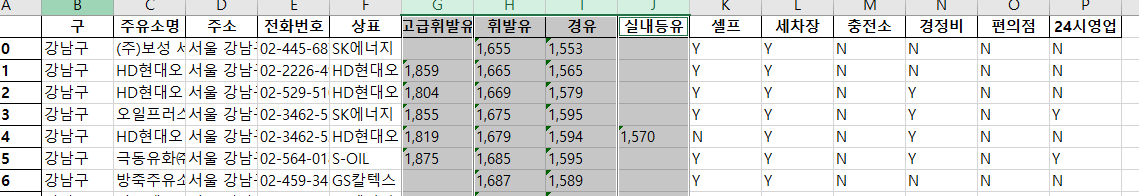

- 고급 휘발유 부터 dataframe 재가공  

1. 먼저 공란을 na로 바꿔준다
2. 고급 휘발유에 없는 값(na) 삭제


In [33]:

df = df.replace('', pd.NA)
df_h_gasoline = df.drop(labels=['휘발유','경유','실내등유'],axis=1)#다른 연료 제거

df_h_gasoline.head()

,구,주유소명,주소,전화번호,상표,고급휘발유,셀프,세차장,충전소,경정비,편의점,24시영업
0,강남구,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),02-445-6870,SK에너지,<NA>,Y,Y,N,N,N,N
1,강남구,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,02-2226-4963,HD현대오일뱅크,"1,859",Y,Y,N,N,N,N
2,강남구,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),02-3462-5100,SK에너지,"1,855",Y,Y,N,Y,N,Y
3,강남구,극동유화㈜ 개나리주유소,서울 강남구 언주로 423 (역삼동),02-564-0186,S-OIL,"1,875",Y,Y,N,Y,N,Y
4,강남구,방죽주유소,서울 강남구 밤고개로 215 (율현동),02-459-3434,GS칼텍스,<NA>,Y,Y,N,N,N,N


In [34]:
df_h_gasoline = df_h_gasoline.dropna() 

df_h_gasoline.head()

,구,주유소명,주소,전화번호,상표,고급휘발유,셀프,세차장,충전소,경정비,편의점,24시영업
1,강남구,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,02-2226-4963,HD현대오일뱅크,"1,859",Y,Y,N,N,N,N
2,강남구,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),02-3462-5100,SK에너지,"1,855",Y,Y,N,Y,N,Y
3,강남구,극동유화㈜ 개나리주유소,서울 강남구 언주로 423 (역삼동),02-564-0186,S-OIL,"1,875",Y,Y,N,Y,N,Y
5,강남구,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),02-529-5101,HD현대오일뱅크,"1,804",Y,Y,N,Y,N,N
7,강남구,HD현대오일뱅크㈜직영 유진주유소,서울 강남구 논현로 152 (도곡동),02-3462-5215,HD현대오일뱅크,"1,819",N,Y,N,Y,N,N


In [35]:
df_h_gasoline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 1 to 1257
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   구       811 non-null    object
 1   주유소명    811 non-null    object
 2   주소      811 non-null    object
 3   전화번호    811 non-null    object
 4   상표      811 non-null    object
 5   고급휘발유   811 non-null    object
 6   셀프      811 non-null    object
 7   세차장     811 non-null    object
 8   충전소     811 non-null    object
 9   경정비     811 non-null    object
 10  편의점     811 non-null    object
 11  24시영업   811 non-null    object
dtypes: object(12)
memory usage: 82.4+ KB


- 나머지 연료들도 동일 작업

In [36]:
df_gasoline = df.drop(labels=['고급휘발유','경유','실내등유'],axis=1)#보통 휘발유 외 다른 연료 제거
df_diesel = df.drop(labels=['고급휘발유','휘발유','실내등유'],axis=1)#경유 외 다른 연료 제거
df_kerosene = df.drop(labels=['고급휘발유','휘발유','경유'],axis=1)#등유 외 다른 연료 제거

df_gasoline = df_gasoline.dropna()
df_diesel = df_diesel.dropna()
df_kerosene = df_kerosene.dropna()



- 구,주유소명,주소로 각 연료 값을 합친다 PD.MERGE (합집합)   
-> 구,주유소별 가격 한번에 확인 가능

In [37]:
df_total = pd.merge(df_h_gasoline, df_gasoline, how='outer')
df_total = pd.merge(df_total, df_diesel, how='outer')
df_total = pd.merge(df_total, df_kerosene, how='outer')

df_total = df_total.set_index('구')

In [38]:
df_total

,주유소명,주소,전화번호,상표,고급휘발유,셀프,세차장,충전소,경정비,편의점,24시영업,휘발유,경유,실내등유
구,,,,,,,,,,,,,,
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
중랑구,용마로주유소,서울 중랑구 용마산로 309 (면목동),02-439-3037,SK에너지,NaN,Y,Y,N,N,N,N,"1,658","1,538","1,600"
중랑구,우림주유소,서울 중랑구 용마산로 487 (망우제3동),02-433-9990,GS칼텍스,NaN,Y,Y,N,N,N,N,"1,607","1,507",NaN
중랑구,우림주유소,서울 중랑구 용마산로 487 (망우제3동),02-433-9990,GS칼텍스,NaN,Y,Y,N,N,N,N,"1,607","1,507",NaN


- 중복값을 제거해준다

In [39]:
df_total = df_total.drop_duplicates()

df_total

,주유소명,주소,전화번호,상표,고급휘발유,셀프,세차장,충전소,경정비,편의점,24시영업,휘발유,경유,실내등유
구,,,,,,,,,,,,,,
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027",Y,Y,N,N,N,Y,"1,797","1,727",NaN
강남구,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),02-518-5141,GS칼텍스,"2,838",N,Y,N,N,N,N,"2,598","2,560","1,850"
강남구,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),02-445-6870,SK에너지,NaN,Y,Y,N,N,N,N,"1,655","1,553",NaN
강남구,(주)선진도곡주유소,서울 강남구 도곡로 162 (도곡동),02-2058-3024,S-OIL,"1,869",N,Y,N,Y,N,N,"1,739","1,635",NaN
강남구,(주)소모 쎈트럴주유소,서울 강남구 삼성로 335,02-565-0267,GS칼텍스,"2,385",N,Y,N,N,N,N,"2,195","2,086","1,650"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
중랑구,신내주유소,서울 중랑구 용마산로 705 (신내동),02-2207-0523,SK에너지,NaN,Y,Y,N,N,N,N,"1,652","1,553","1,450"
중랑구,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),02-436-3651,SK에너지,NaN,Y,Y,N,Y,N,Y,"1,659","1,568","1,590"
중랑구,오천만주유소,서울 중랑구 동일로 547 (면목동),070-7797-7474,S-OIL,NaN,Y,Y,N,N,N,N,"1,607","1,507",NaN


- Column 보기좋게 재배치

In [40]:
df_total = df_total[['주유소명', '주소', '전화번호', '상표', '고급휘발유','휘발유', '경유', '실내등유', '셀프', '세차장', '충전소', '경정비', '편의점',
       '24시영업']]

df_total

,주유소명,주소,전화번호,상표,고급휘발유,휘발유,경유,실내등유,셀프,세차장,충전소,경정비,편의점,24시영업
구,,,,,,,,,,,,,,
강남구,(유)동하석유 힐탑셀프주유소,서울 강남구 논현로 640,02-544-4075,SK에너지,"2,027","1,797","1,727",NaN,Y,Y,N,N,N,Y
강남구,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),02-518-5141,GS칼텍스,"2,838","2,598","2,560","1,850",N,Y,N,N,N,N
강남구,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),02-445-6870,SK에너지,NaN,"1,655","1,553",NaN,Y,Y,N,N,N,N
강남구,(주)선진도곡주유소,서울 강남구 도곡로 162 (도곡동),02-2058-3024,S-OIL,"1,869","1,739","1,635",NaN,N,Y,N,Y,N,N
강남구,(주)소모 쎈트럴주유소,서울 강남구 삼성로 335,02-565-0267,GS칼텍스,"2,385","2,195","2,086","1,650",N,Y,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
중랑구,신내주유소,서울 중랑구 용마산로 705 (신내동),02-2207-0523,SK에너지,NaN,"1,652","1,553","1,450",Y,Y,N,N,N,N
중랑구,신일셀프주유소,서울 중랑구 상봉로 58 (망우동),02-436-3651,SK에너지,NaN,"1,659","1,568","1,590",Y,Y,N,Y,N,Y
중랑구,오천만주유소,서울 중랑구 동일로 547 (면목동),070-7797-7474,S-OIL,NaN,"1,607","1,507",NaN,Y,Y,N,N,N,N


- 26197 rows × 14 columns -> 433 rows × 14 columns 주유소별로 가격 및 부가정보 total list 생성 완료  
-> 엑셀로 저장

In [41]:
df_total.to_excel("seoul_gas_station_total.xlsx")
df_total.to_csv('seoul_gas_station_total.csv', encoding='utf-8')


구 기준 주요소 별 가격,부가정보 데이터 정보 생성 완료  
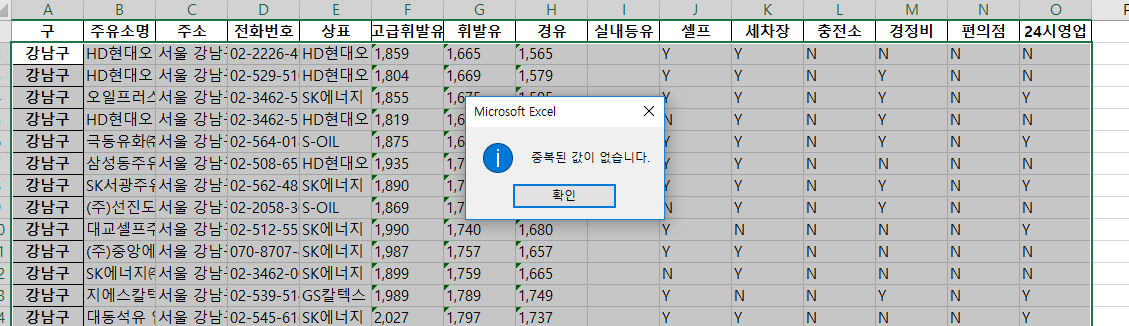

####        1-2. 브랜드 비교(보통 휘발유, 경유)

- 데이터 확인

In [42]:
gas_station_anal = pd.read_csv('seoul_gas_station_total.csv', encoding='utf-8', thousands=',', index_col=0)
gas_station_anal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 강남구 to 중랑구
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   주유소명    436 non-null    object 
 1   주소      436 non-null    object 
 2   전화번호    436 non-null    object 
 3   상표      436 non-null    object 
 4   고급휘발유   245 non-null    float64
 5   휘발유     436 non-null    int64  
 6   경유      436 non-null    int64  
 7   실내등유    141 non-null    float64
 8   셀프      436 non-null    object 
 9   세차장     436 non-null    object 
 10  충전소     436 non-null    object 
 11  경정비     436 non-null    object 
 12  편의점     436 non-null    object 
 13  24시영업   436 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 51.1+ KB


- 데이터 시각화

In [43]:
import matplotlib.pyplot as plt
import koreanize_matplotlib


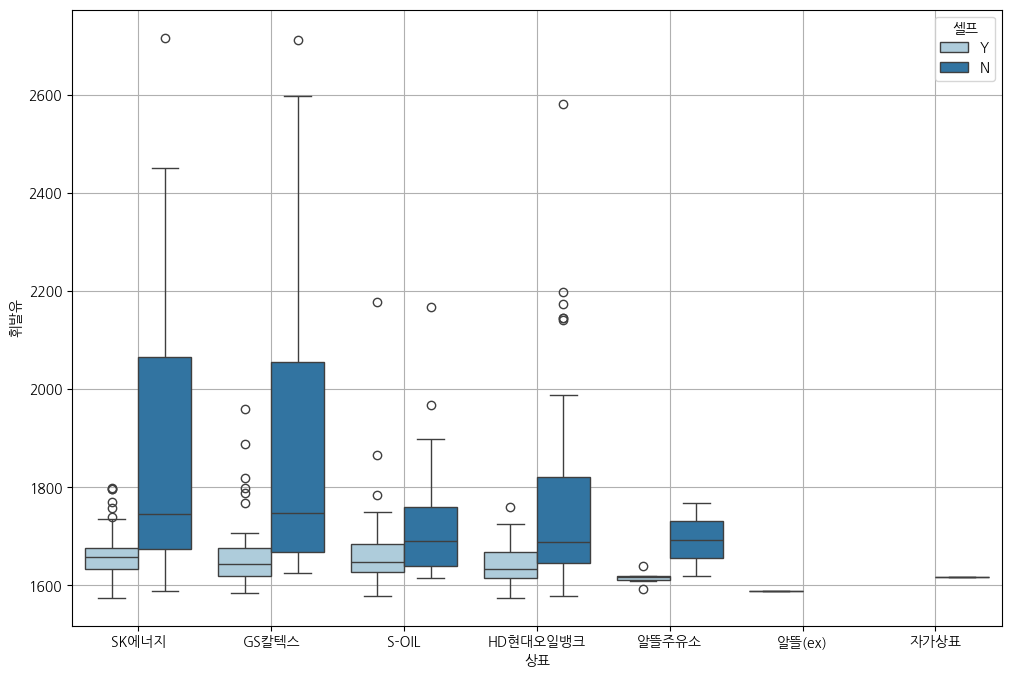

In [44]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="상표", y="휘발유", hue="셀프", data=gas_station_anal, palette="Paired")
plt.grid(True)
plt.show()

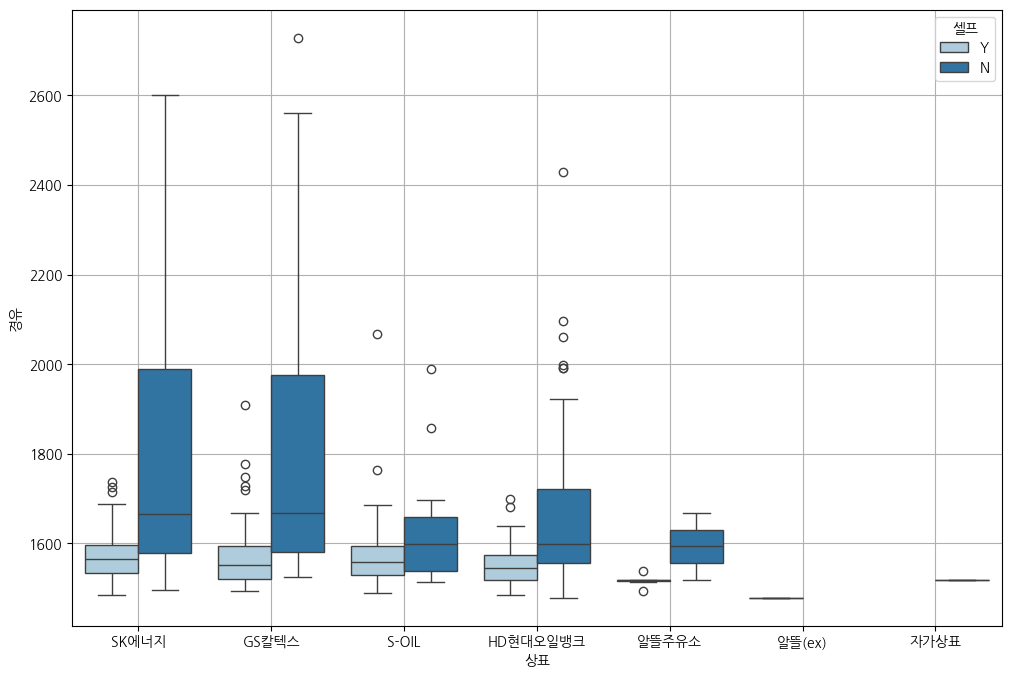

In [45]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="상표", y="경유", hue="셀프", data=gas_station_anal, palette="Paired")
plt.grid(True)
plt.show()

- 비싼 주유소 순 정렬

In [46]:
gas_station_anal.sort_values(by="휘발유", ascending=False).head(10)

,주유소명,주소,전화번호,상표,고급휘발유,휘발유,경유,실내등유,셀프,세차장,충전소,경정비,편의점,24시영업
구,,,,,,,,,,,,,,
중구,서남주유소,서울 중구 통일로 30,02-752-9475,SK에너지,3116.0,2716,2600,2219.0,N,Y,N,N,N,Y
용산구,서계주유소,서울 용산구 청파로 367 (청파동),02-706-6485,GS칼텍스,3109.0,2712,2729,2370.0,N,Y,N,N,N,N
강남구,(주)만정에너지 삼보주유소,서울 강남구 봉은사로 433 (삼성동),02-518-5141,GS칼텍스,2838.0,2598,2560,1850.0,N,Y,N,N,N,N
강남구,(주)제이제이네트웍스 제이제이주유소,서울 강남구 언주로 716,02-518-5631,HD현대오일뱅크,2850.0,2580,2430,NaN,N,Y,N,N,N,Y
중구,필동주유소,서울 중구 퇴계로 196 (필동2가),02-2267-8025,GS칼텍스,2739.0,2489,2369,1859.0,N,N,N,N,N,Y
강남구,SK논현주유소,서울 강남구 논현로 747 (논현동),02-511-0955,SK에너지,2690.0,2450,2295,1798.0,N,Y,N,Y,N,Y
용산구,한석주유소,서울 용산구 이촌로 164,02-790-1020,SK에너지,2552.0,2318,2170,NaN,N,Y,N,N,N,Y
영등포구,SJ오일(주) 여의도주유소,서울 영등포구 은행로 64,02-785-8201,GS칼텍스,2415.0,2295,2395,1750.0,N,Y,Y,N,Y,Y
종로구,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65 (사직동),02-735-4858,GS칼텍스,2495.0,2295,2185,1800.0,N,N,N,N,N,N


- 값싼 주유소 순 정렬

In [47]:
gas_station_anal.sort_values(by="휘발유", ascending=True).head(10)

,주유소명,주소,전화번호,상표,고급휘발유,휘발유,경유,실내등유,셀프,세차장,충전소,경정비,편의점,24시영업
구,,,,,,,,,,,,,,
영등포구,남서울고속주유소,서울 영등포구 가마산로 367 (대림동),02-843-5151,SK에너지,1755.0,1575,1485,NaN,Y,Y,N,N,N,Y
영등포구,영등포제일셀프주유소,서울 영등포구 가마산로 379,02-847-5151,HD현대오일뱅크,NaN,1575,1485,NaN,Y,Y,N,Y,N,N
마포구,(주)타이거통상 월드컵주유소,서울 마포구 월드컵북로 170 (성산제2동),070-4121-0021,S-OIL,1829.0,1579,1489,NaN,Y,N,N,N,N,N
은평구,(주)디오티디 은평유니콘주유소,서울 은평구 통일로 1151 (진관동),02-356-9051,HD현대오일뱅크,1774.0,1579,1479,1484.0,N,Y,N,N,N,N
영등포구,(주)대청에너지 대청주유소,서울 영등포구 가마산로 328 (대림동),02-841-8780,GS칼텍스,NaN,1585,1495,NaN,Y,Y,N,Y,N,Y
서초구,만남의광장주유소,서울 서초구 양재대로12길 73-71,02-573-7430,알뜰(ex),NaN,1589,1479,NaN,Y,N,Y,N,Y,Y
마포구,마포시엠주유소,서울 마포구 월드컵북로 62,02-338-9447,SK에너지,NaN,1589,1499,NaN,N,N,N,N,N,N
도봉구,이케이에너지 주식회사,서울 도봉구 도봉로 941 (도봉동),02-3494-3641,HD현대오일뱅크,NaN,1590,1495,NaN,Y,Y,N,N,N,N
구로구,서서울고속주유소,서울 구로구 경인로 150 (오류동),02-2683-1126,SK에너지,1779.0,1592,1494,NaN,Y,Y,N,N,N,Y


In [48]:
for_maps = pd.pivot_table(data=gas_station_anal, index="구", values="휘발유", aggfunc=np.mean)
for_maps.head()

/tmp/ipykernel_6661/298285949.py:1: FutureWarning: The provided callable <function mean at 0x7f721c7dbbe0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  for_maps = pd.pivot_table(data=gas_station_anal, index="구", values="휘발유", aggfunc=np.mean)


,휘발유
구,
강남구,1920.281250
강동구,1737.928571
강북구,1620.916667
강서구,1673.818182
관악구,1696.571429


- 지도로 표시

In [55]:
geo_path = "/home/min/dev_ws/EDA/data/task/skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding = "utf-8"))

map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="OpenStreetMap")
folium.Choropleth(geo_data=geo_str,
                  data=for_maps,
                  columns=[for_maps.index, '휘발유'],
                  key_on='feature.id',
                  fill_color='PuRd').add_to(map)
                              
map

In [56]:
driver.close()